In [10]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms 
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

import random
from torch.utils.data import Dataset
import os
import copy

In [11]:
input_size    = 784
hidden_size   = 500 
num_classes   = 10 
num_epochs    = 100
batch_size    = 100
learning_rate = 1e-3

In [12]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

In [13]:
train = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          num_workers = 1,
                                          shuffle=True)

test = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers = 1,
                                          shuffle=True)

In [14]:
class Net_border(nn.Module): #Net_boarder -> Net_border
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net_border, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
                       
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2)) 
        self.relu2 = nn.ReLU() 
            
        self.fc3 = nn.Linear(int(hidden_size/2), int(hidden_size/4)) 
        self.relu3 = nn.ReLU() 
            
        self.fc4 = nn.Linear(int(hidden_size/4), num_classes) 
    
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.relu(out)
                                
        out = self.fc2(out)
        out = self.relu2(out)   
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        return out

In [15]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() 
                       
        self.fc2 = nn.Linear(hidden_size, int(hidden_size)) 
        self.relu2 = nn.ReLU() 
            
        self.fc4 = nn.Linear(int(hidden_size), num_classes) 
        
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x): 
        
#         x = self.dropout(x)
        out = self.fc1(x)
        out = self.relu(out)

#         out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)   
        
#         out = self.dropout(out)        
        out = self.fc4(out)
        return out

In [16]:
def acc(n, train):

    correct = 0
    total = 0

    for images, labels in train:
        images = Variable(images.view(-1, 28*28))
        outputs = n(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)                   
        correct += (predicted == labels).sum()     

    print('Accuracy of the network train images: %d %%' % (100 * correct / total))


In [17]:
net = Net_border(input_size, hidden_size, num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [9]:
# border_losses = []
# for epoch in range(100):
#     for i, (images, labels) in enumerate(train):   
#         images = Variable(images.view(-1, 28*28))         
#         labels = Variable(labels)
              
#         optimizer.zero_grad()                             
#         outputs = net(images)                             
#         loss = criterion(outputs, labels)                 
#         loss.backward()                                   
#         optimizer.step()                                  
        
#         border_losses.append(loss.item())
        
#         if (i+1) % 600 == 0:   
    
#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs*10, i+1, len(train)//batch_size, loss.item()))



In [10]:
# acc(net, train)

In [11]:
# torch.save(net.state_dict(), 'nn_boarders.pt') 

In [18]:
net = Net_border(input_size, hidden_size, num_classes)
net.state_dict = net.load_state_dict(torch.load('nn_boarders.pt'))


This is the net used for finding the borders

In [19]:
acc(net, train)

Accuracy of the network train images: 99 %


This is the net that uses the difference between the two highest outputs.

In [20]:
net2 = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

min_threshold = 0.1

f_label = []

failure_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train):   
        images = Variable(images.view(-1, 28*28))  
        labels = Variable(labels)
        a = labels

        ###
        outputs = net(images)
        for j, o in enumerate(outputs):
            tmp = (o-min(o))/(max(o)-min(o))

            diff = torch.sort(tmp,descending=True)[1][0] - torch.sort(tmp,descending=True)[1][1]
            if (diff < min_threshold):
                labels[j] = torch.sort(o,descending=True)[1][1]
        ###
    
        f_label.append(labels)
        
        optimizer.zero_grad()                             
        outputs2 = net2(images)                             
        loss = criterion(outputs2, labels)                 
        loss.backward()                                   
        optimizer.step()    
        
        failure_losses.append(loss.item())
        
        if (i+1) % 600 == 0:   

            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.item()))

print(acc(net2,train))

## Evaluate the model
correct = 0
total = 0
i = 0
for images2, labels2 in test:
    
    images = Variable(images2.view(-1, 28*28))
    
    
    outputs = net2(images)
    _, predicted = torch.max(outputs.data, 1)  
    total += labels2.size(0)                   
    correct += (predicted == labels2).sum()     
    i += 1
    
# img = images2[i-1][0,:,:]
# plt.imshow(img, cmap='gray')
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Epoch [1/100], Step [600/6], Loss: 2.1494
Epoch [2/100], Step [600/6], Loss: 2.0407
Epoch [3/100], Step [600/6], Loss: 1.9258
Epoch [4/100], Step [600/6], Loss: 1.8381
Epoch [5/100], Step [600/6], Loss: 1.6434
Epoch [6/100], Step [600/6], Loss: 1.7169
Epoch [7/100], Step [600/6], Loss: 1.5245
Epoch [8/100], Step [600/6], Loss: 1.4637
Epoch [9/100], Step [600/6], Loss: 1.3482
Epoch [10/100], Step [600/6], Loss: 1.3999
Epoch [11/100], Step [600/6], Loss: 1.2940
Epoch [12/100], Step [600/6], Loss: 1.3149
Epoch [13/100], Step [600/6], Loss: 1.1955
Epoch [14/100], Step [600/6], Loss: 1.0627
Epoch [15/100], Step [600/6], Loss: 1.0830
Epoch [16/100], Step [600/6], Loss: 1.1065
Epoch [17/100], Step [600/6], Loss: 0.9998
Epoch [18/100], Step [600/6], Loss: 1.0272
Epoch [19/100], Step [600/6], Loss: 1.1009
Epoch [20/100], Step [600/6], Loss: 0.7886
Epoch [21/100], Step [600/6], Loss: 1.1150
Epoch [22/100], Step [600/6], Loss: 0.9958
Epoch [23/100], Step [600/6], Loss: 0.8203
Epoch [24/100], Step

This is the net that selects points based on a threshold

In [21]:
# if the diff between 1st and 2nd is small
def find_border(outputs, threshold): 
    output = np.zeros(len(outputs))
    for i, o in enumerate(outputs.data):
        tmp = (o-min(o))/(max(o)-min(o))
        tmp[tmp<threshold] = 0
        if (sum(tmp)>1):
            output[i] = 1
            
    return(output)

In [22]:
learning_rate = 1e-3
#####
threshold = 0.8

In [17]:
net2 = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

f_label = []

failure_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train):   
        images = Variable(images.view(-1, 28*28))  
        labels = Variable(labels)

        ###
        outputs = net(images)
        idx = find_border(outputs,threshold)
        if(sum(idx) > 1):
            out = outputs[idx==1]
            my_idx = np.where(idx == 1)[0]
            for j, o in enumerate(out):
#                 torch.sort(o,descending=True)[1][1]
                labels[my_idx[j]] = torch.sort(o,descending=True)[1][1]
        ###
    
        f_label.append(labels)
        
        optimizer.zero_grad()                             
        outputs2 = net2(images)                             
        loss = criterion(outputs2, labels)                 
        loss.backward()                                   
        optimizer.step()    
        
        failure_losses.append(loss.item())
        
#         if (i+1) % 600 == 0:   

#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.item()))

print(acc(net2,train))

## Evaluate the model
correct = 0
total = 0
i = 0
for images2, labels2 in test:
    
    images = Variable(images2.view(-1, 28*28))
    
    
    outputs = net2(images)
    _, predicted = torch.max(outputs.data, 1)  
    total += labels2.size(0)                   
    correct += (predicted == labels2).sum()     
    i += 1
    
# img = images2[i-1][0,:,:]
# plt.imshow(img, cmap='gray')
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network train images: 92 %
None
Accuracy of the network on the 10K test images: 92 %


This is a normal net 

In [18]:
net3 = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(net3.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train):   
        images = Variable(images.view(-1, 28*28))         
        labels = Variable(labels)
              
        optimizer.zero_grad()                             
        outputs = net3(images)                             
        loss = criterion(outputs, labels)                 
        loss.backward()                                   
        optimizer.step()  
        
        losses.append(loss.item())
        
#         if (i+1) % 600 == 0:   

#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs*5, i+1, len(train)//batch_size, loss.item()))

In [19]:
acc(net3, train)

## Evaluate the model
correct = 0
total = 0
i = 0
for images2, labels2 in test:
    
    images = Variable(images2.view(-1, 28*28))
    
    
    outputs = net3(images)
    _, predicted = torch.max(outputs.data, 1)  
    total += labels2.size(0)                   
    correct += (predicted == labels2).sum()     
    i += 1
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network train images: 92 %
Accuracy of the network on the 10K test images: 92 %


Creating data for plotting pca + tsne

In [20]:
data_to_append = []
all_labels = []
f_label = []
conf_labels = []
conf_ints = []
for images, labels in train:

    ###
    f_ = copy.deepcopy (labels)
    outputs = net(Variable(images.view(-1, 28*28))  )
    idx = find_border(outputs,threshold)

    if(sum(idx) > 1):
        out = outputs[idx==1]
        my_idx = np.where(idx == 1)[0]
        for i, o in enumerate(out):
            f_[my_idx[i]] = torch.sort(o,descending=True)[1][1]

    ###
    for j in range(int(batch_size/10)):

        all_labels.append(labels[j].numpy())
        f_label.append(f_[j].numpy())
        

        conf_ints.append(outputs[j].detach().numpy())

        tmp = (images[j])
        tmp = Variable(tmp.view(-1, 28*28))
        tmp = torch.flatten(tmp)
        data_to_append.append(tmp.numpy())

In [21]:
my_labels2 = pd.DataFrame(f_label)
my_labels2.columns = ["label"]

In [22]:
my_images = pd.DataFrame(data_to_append)
my_labels = pd.DataFrame(all_labels)
my_labels.columns = ["label"]

In [23]:
my_confs = pd.DataFrame(conf_ints)

In [24]:
# tsne_label = my_labels["label"]

pca = PCA(n_components=50)
tsne = TSNE(n_components = 2, random_state=0)

pca_res_50 = pca.fit_transform(my_images)
tsne_res = tsne.fit_transform(pca_res_50)



These Figures show the normal data,  first, and the data with changed data given the threshold

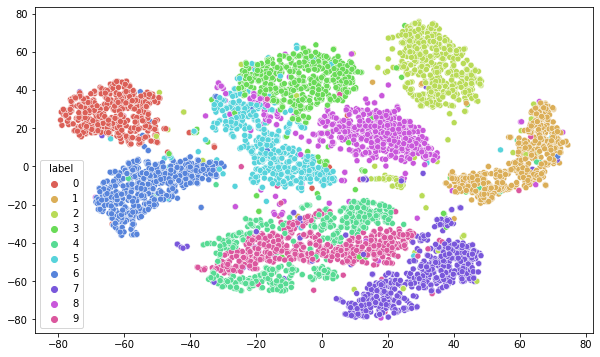

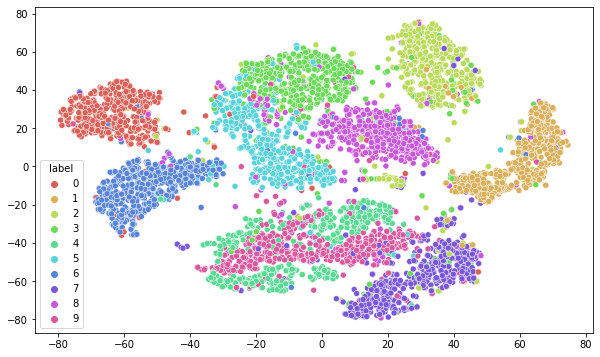

In [25]:
plt.figure(figsize=(10,6))

sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = my_labels["label"], palette = sns.hls_palette(10), legend = 'full');

plt.figure(figsize=(10,6))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = my_labels2["label"], palette = sns.hls_palette(10), legend = 'full');

Converge plot of loss function, red is tradicional net and blue our threshold net

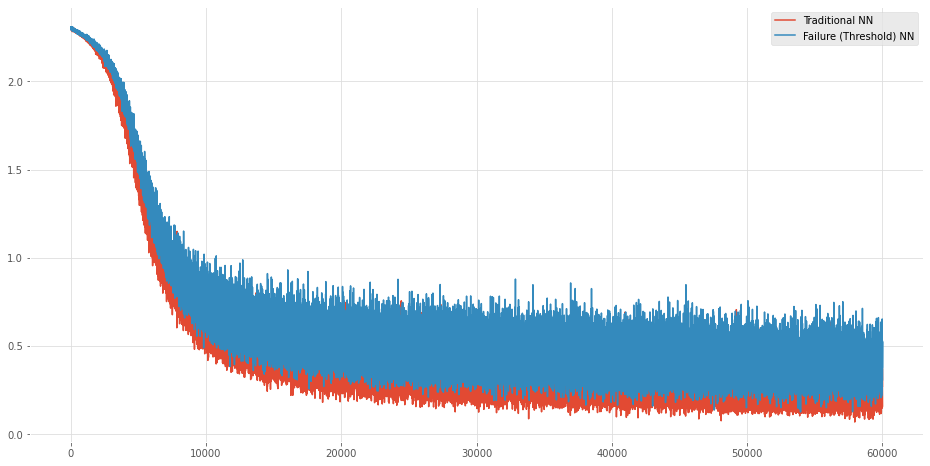

In [26]:
figsize_y = 4
figsize_x = 8

plt.style.use('ggplot')
plt.figure(figsize=(figsize_x*2,figsize_y*2))
ax = plt.axes()
ax.set(facecolor = "white")
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)


plt.plot(np.array(losses), label="Traditional NN")#, lw=1, marker='^', ms=4) # triangle
plt.plot(np.array(failure_losses), label="Failure (Threshold) NN")#, lw=1, marker='^', ms=4) # triangle
# plt.plot(np.array(border_losses), label="Border NN")#, lw=1, marker='^', ms=4) # triangle

plt.legend()

These Figures show the confidence intervals: first of the normal net and then the threshold net

In [27]:
pca = PCA(n_components=6)
tsne = TSNE(n_components = 2, random_state=0)

my_pca = pca.fit_transform(my_confs)
tsne_res = tsne.fit_transform(my_pca)

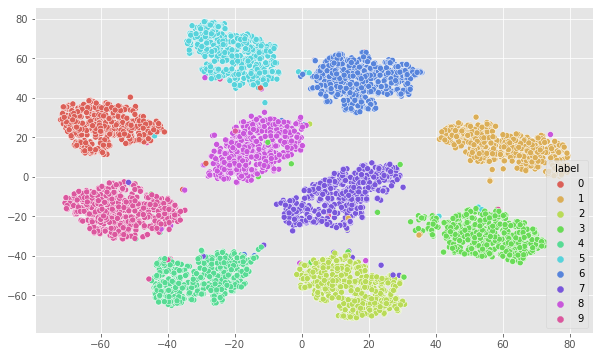

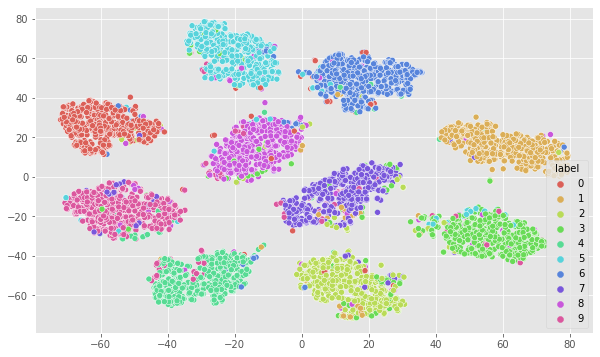

In [28]:

plt.figure(figsize=(10,6))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = my_labels["label"] , palette = sns.hls_palette(10), legend = 'full');

plt.figure(figsize=(10,6))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = my_labels2["label"] , palette = sns.hls_palette(10), legend = 'full');


#### 